In [1]:
from models import CMGN, MMGN, MLP
from models import GMMSampler, MMDDistance, DualWassersteinDistance, GaussianKLDivergence

## First example: Transporting Gaussian Distributions

We model how to transport simple gaussian distributions. We test:
- Using the KLL between the estimated density, consdidered Gaussian, and the target density.
- Using the KL Divergence with the same setup.
- Using the Wasserstein Distance between the generated points and the target distribution, in an adversarial fashion.

Let's begin by generating some example data:

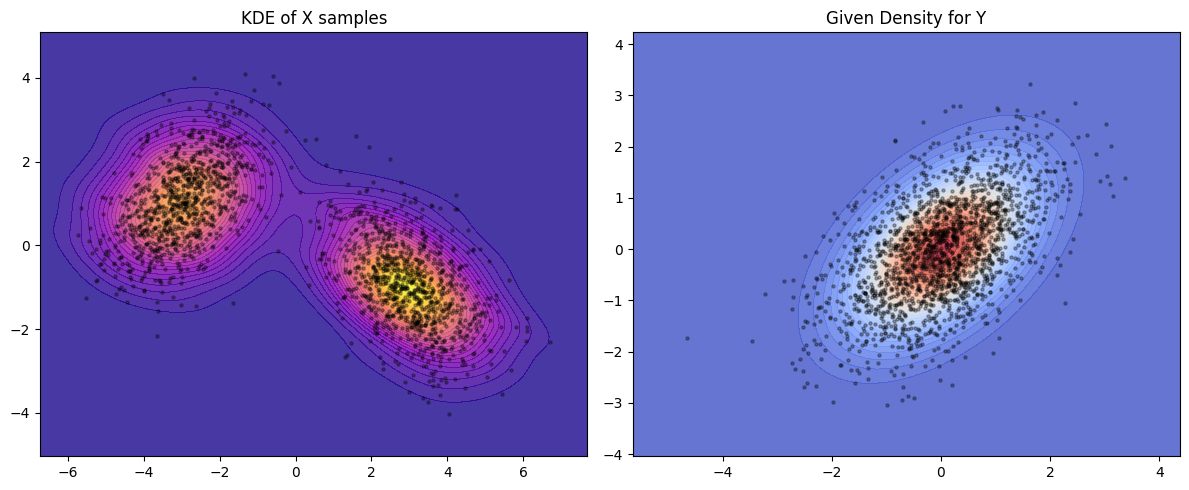

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from plot_utils import plot_kde_comparison

x_gmm_centers = np.array([[-3, 1], [3, -1]])
x_covs = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]]])

# x_gmm_centers = np.array([[-3, 1]])
# x_covs = np.array([[[2, 2], [2, 3]]])

x_gmm = GMMSampler(x_gmm_centers, covs=x_covs, weights=None)



y_gmm_centers = np.array([[0, 0]])
y_covs = np.array([[[1, 0.5], [0.5, 1]]])
y_gmm = GMMSampler(y_gmm_centers, covs=y_covs, weights=None)

n_samples = 2000
x_samples = x_gmm.sample(n_samples)
y_samples = y_gmm.sample(n_samples)
p_y = lambda y: torch.exp(y_gmm.log_likelihood(torch.Tensor(y).T))

plot_kde_comparison(x_samples, y_samples, p_y=p_y, left_title='KDE of X samples')

In [3]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_dim = x_gmm.means[0].shape[0]
hidden_dim = 64
v_dim = 64
num_layers = 2
activation = nn.ReLU()

T = CMGN(hidden_dim, v_dim, x_dim, num_layers, activation).to(device) # Notre transport


learning_rate = 0.005
iterations = 300
batch_size = 2048


divergence_metric = GaussianKLDivergence(target_mean=y_gmm.means[0], target_cov=y_gmm.covs[0], device=device)

# wasserstein_distance = AdversarialWassersteinDistance(
#     input_dim=2, 
#     hidden_dim=128,
#     critic_lr=0.005,
#     critic_iterations=50,
#     clip_value=0.01
# )
# wasserstein_distance.critic.to(device)

# # Create MMD distance calculator
# mmd_distance = MMDDistance(kernel_width=0.5)




In [4]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from IPython.display import HTML

def plot_kde(samples, ax, cmap, density_fn=None, scatter=True):
    x, y = samples[:, 0], samples[:, 1]

    # Define grid
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

    # Compute density
    if density_fn:
        zz = density_fn(xx, yy)
    else:
        kde = gaussian_kde(np.vstack([x, y]))
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

    # Plot
    ax.contourf(xx, yy, zz, levels=30, cmap=cmap, alpha=0.8)
    if scatter:
        ax.scatter(x, y, s=5, color='black', alpha=0.3)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

def train_OT(source_sampler, target_sampler, learning_rate, iterations, model, batch_size, distribution_distance, lmbd=0.1, device='cuda'):
    losses = []
    T_x_history = []

    gradient_net = model.to(device)  # gradient net = ∇ψ = T = ce qu'on veut apprendre
    optimizer = torch.optim.Adam(gradient_net.parameters(), lr=learning_rate)

    # Create a tqdm progress bar
    progress_bar = tqdm(range(iterations), desc="Training Progress")

    for i in progress_bar:
        x_batch = source_sampler.sample(batch_size).to(device)
        y_batch = target_sampler.sample(batch_size).to(device)

        T_x = gradient_net(x_batch) / 25

        # Compute distribution matching penalty
        loss = distribution_distance(T_x, y_batch)

        if hasattr(distribution_distance, 'update'):
            T_x = T_x.detach()
            distribution_distance.update(T_x, y_batch)

        # Total loss
        losses.append(loss.item())

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the transported samples for animation
        T_x_history.append(T_x.detach().cpu().numpy())

        if i % 50 == 0:
            with torch.no_grad():
                T_x_np = T_x.detach().cpu().numpy()
                y_samples = y_batch.detach().cpu()
                p_y = lambda y: torch.exp(y_gmm.log_likelihood(torch.Tensor(y).T)).cpu().numpy()
                plot_kde_comparison(T_x_np, y_samples, p_y=p_y, left_title='KDE of X samples')

    # Smooth the loss curve using a moving average
    window_size = 10
    smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

    # Plot the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Loss', alpha=0.6)
    plt.plot(range(window_size-1, iterations), smoothed_losses, label='Smoothed Loss', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Iterations')
    plt.grid(True)
    plt.legend()
    plt.xticks(range(0, iterations, 50))
    plt.show()

    # Compute the limits for the plot
    all_samples = np.vstack(T_x_history)
    xmin, xmax = all_samples[:, 0].min() - 1, all_samples[:, 0].max() + 1
    ymin, ymax = all_samples[:, 1].min() - 1, all_samples[:, 1].max() + 1

    # Compute mean and covariance for y samples
    y_samples = target_sampler.sample(batch_size).cpu().numpy()
    y_mean = np.mean(y_samples, axis=0)
    y_cov = np.cov(y_samples, rowvar=False)

    # Create an animation for the evolution of T_x
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_ylim(ymin, ymax)
    axes[1].set_xlim(xmin, xmax)
    axes[1].set_ylim(ymin, ymax)

    # Plot the target distribution (assuming p_y is available)
    density_fn = lambda X, Y: p_y(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    plot_kde(T_x_history[0], axes[1], cmap='coolwarm', density_fn=density_fn, scatter=False)
    axes[1].set_title('Target Distribution')

    def init():
        axes[0].clear()
        axes[0].set_xlim(xmin, xmax)
        axes[0].set_ylim(ymin, ymax)
        return []

    def animate(i):
        axes[0].clear()
        axes[0].set_xlim(xmin, xmax)
        axes[0].set_ylim(ymin, ymax)

        T_x_np = T_x_history[i]
        plot_kde(T_x_np, axes[0], cmap='plasma')
        axes[0].set_title(f'Iteration {i}')

        # Compute mean and covariance for T_x samples
        T_x_mean = np.mean(T_x_np, axis=0)
        T_x_cov = np.cov(T_x_np, rowvar=False)

        # Plot mean and covariance for T_x samples
        T_x_mean_plot = axes[0].scatter(T_x_mean[0], T_x_mean[1], color='red', s=100, zorder=5, label='Mean of T_x')
        T_x_cov_plot1 = axes[0].arrow(T_x_mean[0], T_x_mean[1], T_x_cov[0, 0], T_x_cov[0, 1], color='red', head_width=0.1)
        T_x_cov_plot2 = axes[0].arrow(T_x_mean[0], T_x_mean[1], T_x_cov[1, 0], T_x_cov[1, 1], color='red', head_width=0.1)

        # Plot mean and covariance for y samples
        y_mean_plot = axes[0].scatter(y_mean[0], y_mean[1], color='blue', s=100, zorder=5, label='Mean of y')
        y_cov_plot1 = axes[0].arrow(y_mean[0], y_mean[1], y_cov[0, 0], y_cov[0, 1], color='blue', head_width=0.1)
        y_cov_plot2 = axes[0].arrow(y_mean[0], y_mean[1], y_cov[1, 0], y_cov[1, 1], color='blue', head_width=0.1)

        # Add legend
        axes[0].legend(handles=[T_x_mean_plot, y_mean_plot], loc='upper right')

        return []

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=iterations, interval=200, blit=False)

    # Save the animation as a video file
    video_path = 'transported_samples_animation.mp4'
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(video_path, writer=writer)

    # Display the video in the notebook
    return HTML(f"""
        <video width="640" height="480" controls>
            <source src="{video_path}" type="video/mp4">
        </video>
    """)


Training Progress:   0%|          | 0/200 [00:00<?, ?it/s, loss=4.43]

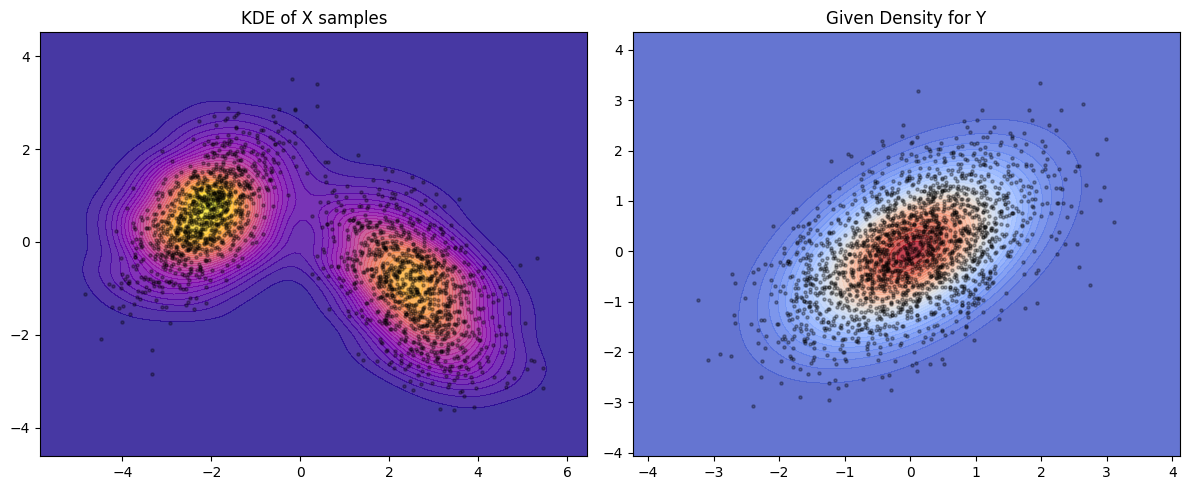

Training Progress:  25%|██▌       | 50/200 [00:20<00:52,  2.83it/s, loss=0.0204]

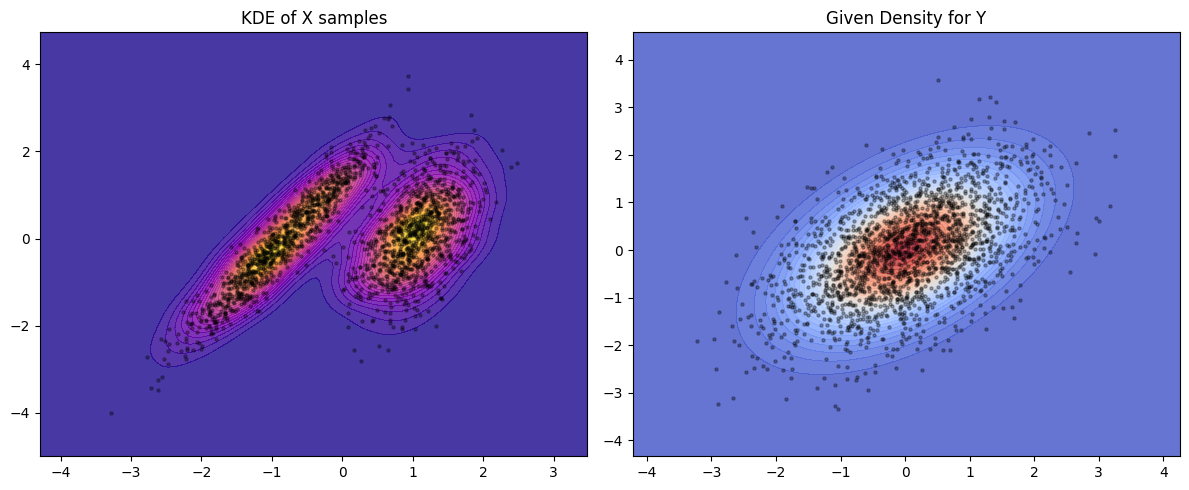

Training Progress:  50%|█████     | 100/200 [00:35<00:25,  3.86it/s, loss=0.00145]

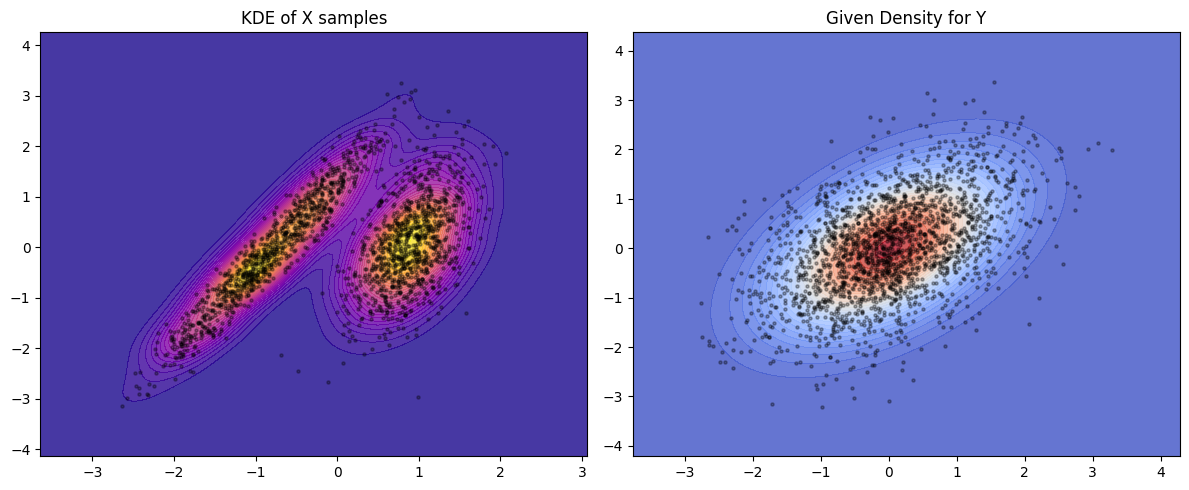

Training Progress:  75%|███████▌  | 150/200 [00:50<00:14,  3.36it/s, loss=0.000557]

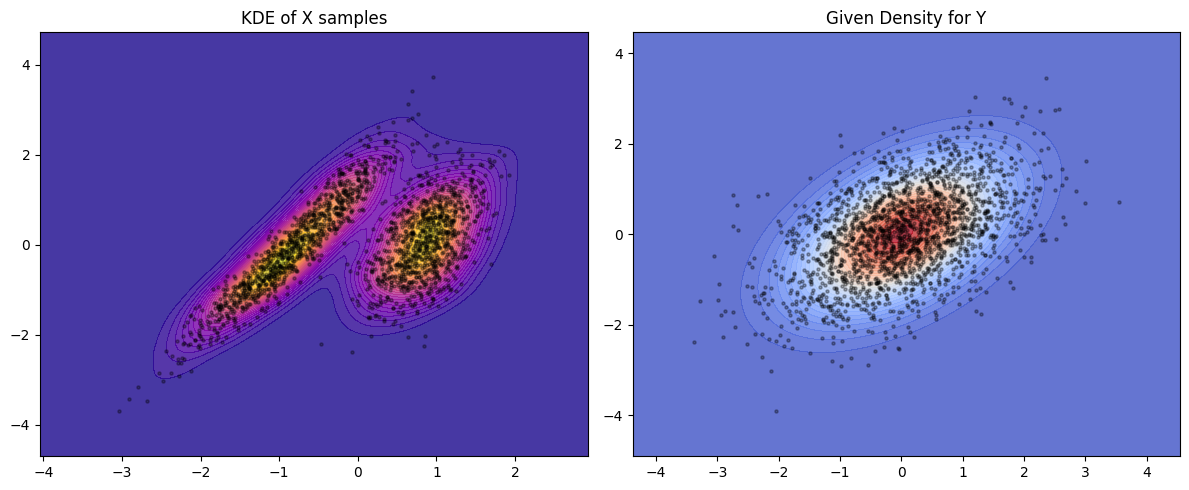

Training Progress: 100%|██████████| 200/200 [01:04<00:00,  3.12it/s, loss=0.00339] 


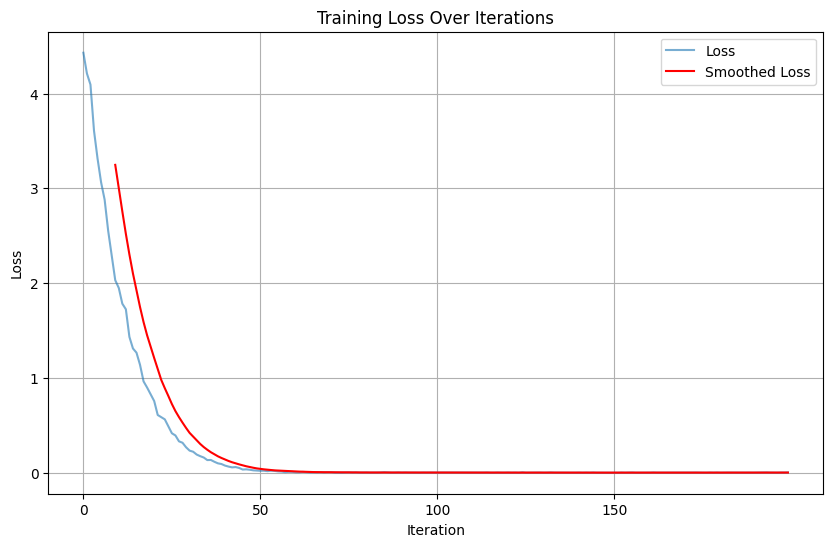

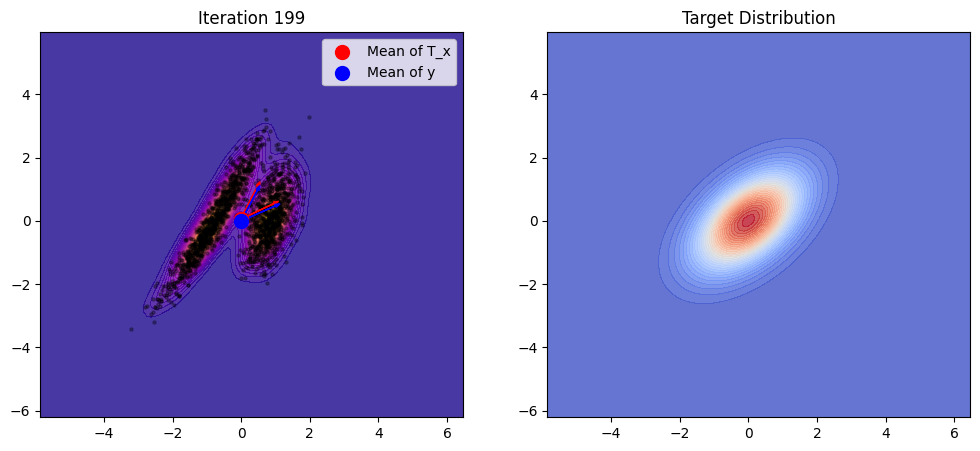

In [5]:
train_OT(
    x_gmm, 
    y_gmm, 
    learning_rate, 
    200, 
    T, 
    batch_size, 
    divergence_metric, 
    device=device
)